# Example 5a - Beachface Cluster Dynamics indices - location level

<img src="images/banner3.png" width="100%" />

<font face="Calibri">
<br>
<font size="5"> <b>Multiscale beachface behavioural modelling: Beachface Cluster Dynamics indices</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>
<img style="padding:7px;" src="images/sandpiper_sand_retouched.png" width="170" align="right" /></font>

<font size="3">These indices represents the tendency of the location, or transect, to either erode or accrete, based on the temporal succession of sand-only change.<br>

<b>This notebook covers the following concepts:</b>

- Modelling BCDs both at the location and transect scales.
- Plotting.
- Sensitivity analysis for transect-level r-BCD.
</font>


</font>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sandpyper.outils import getLoc, getDate,coords_to_points
from sandpyper.dynamics import  BCDs_compute, steady_state_transect, compute_rBCD_transects, infer_weights

crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


We use the __hotspot sand-only beachface points__ that have been previously classified into dh magnitude classes (transient states)

In [2]:
in_file=r"C:\my_packages\doc_data\profiles\markov_tagged_df.csv"
dataset=pd.read_csv(in_file)

dataset["coordinates"]=dataset.geometry.apply(coords_to_points)
dataset_gdf=gpd.GeoDataFrame(dataset, geometry="coordinates",crs=crs_dict_string['mar'])
dataset_gdf.sort_values(['date_pre'], inplace=True)

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Empirical Beachface Cluster Dynamics (e-BCDs)

The function __BCDs_compute__ computes all the stochastic first-order transition matrices of sand dynamics, based on the sand-only hotspots of elevation change across beachface dataset, at the site level, which are the basis for the e-BCDs.

It returns 2 dataframes:
* __e-BCDs__
* __steady-state distribution__

Optionally, it also plots the transition matrices and save them in the specified output folder.


Notes: <br>
>These matrices discard all the __valid to non-valid transitions__. In other words, all transitions going from a valid point (non spatial outlier, classified as sand and beyond limit of detection) are labelled as "nnn" adn discarded.
Moreover, __the colour ramp__ higher limit (vmax parameter) is set to a maximum of 3 times the standard deviation of all dataset without the nnn state.

The __Empirical Beachface Cluster indices (e-BCD)__ uses weights to represent the importance of each transition.<br>
A point that transitioned from small erosion to extreme erosion has more impact on the sediment budget than if it was transitioning to a medium erosion class.<br>
The weights for each magnitude class can be specified manually using a dictionary. However, it is best to obtain an objective representation of the severity of change. As the magnitude classes are derived from the data (using Jenks-Caspall optimised natural breaks method), a simple yet robust solution is to use the medians of each magnitude class as weight.
<br>
<br>
The function __infer_weights__ takes care of this.


In [3]:
# Create the weights dictionary for the classes
weights_dict=infer_weights(dataset)

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Order of the columns
label_order=['ed','hd','md','sd','ud','nnn','ue','se','me','he','ee']

weigths_series

se    0.24
sd    0.24
ue    0.10
ud    0.10
me    0.41
md    0.41
he    0.67
hd    0.67
ee    1.76
ed    1.76
Name: weight, dtype: float64

In [4]:
%%time

# For all the locations, compute e-BCD indices and Steady-States at the location level.

e_bcds,ss = BCDs_compute(dataset, weights_dict=weights_dict,
                         mode='all',
                         plot_it=True, unique_field="geometry", label_order=label_order,
                        save_it=False,fig_size=(8, 8),
                         save_output=None)

NameError: name 'product' is not defined

### Observations

__The title__ informs about:
* mar/leo = Location codes (leo = St. Leonards; mar = Marengo
* n = Total number of points in the timeseries (valid and non-valid)
* t = Total number of timesteps
* trans = Total number of valid transitions considered

__leo__
>We chose St. Leonards as an example to demonstrates a few limitations, which are observable in this matrix.

St. Leonards is located within Port Phillip bay. This narrrow beach is not embayed, but __fetch-limited__, meaning that it doesn't receive the highly energetic Souther Ocean swell, rather, it sees its morphodynamics impacted by considerably lower waves which are locally generated from within the bay. Moreover, seagrass meadows and reefs further reduce wave imapcts on the subaerial beachface.<br>
Therefore, __changes are small__ and often below the limit of detections, thus, uncertain. If we consider that we filter points based on (1) only sand, (2) limit of detection, (3) spatial outliers, from an already narrow beach (short transects) this location is severly decimated in terms of behavioural modelling potential.<br>

In fact, the submatrices have many zeroes, which indicate a zero probability of these transitions, because these have not been recorded.<br>
Moreover, we note how most of the transitions tend to be __from lower magnitude classes to low magnitude classes.__
<br>
Another story for Marengo.

__mar__

Marengo is an open-ocean beach with a small southern section pretected by a small headland (tombolo-like). The section used for this example is also affected by sand nourishment, which injects considerable amount of sediment during the monitoring period.<br>
Given in Marengo we have roughly 4 times the number of valid observations (trans=30'786) as compared to St. Leonards (trans=7'465), the submatrices better capture the stochastic behaviour of this beachface.



### Plotting the e-BCDs

Let's plot the e-BCDs, which summarise the information contained in the submatrices.

In [5]:
# here I translate the submatrix codes into the names and store them in a column

titles=["Erosional", "Recovery", "Depositional","Vulnerability"]

translation=dict(zip(["ee","ed","dd","de"],titles))
e_bcds["states_labels"]=e_bcds["sub_matrix"].map(translation)

e_bcds.query("location=='leo'")

NameError: name 'e_bcds' is not defined

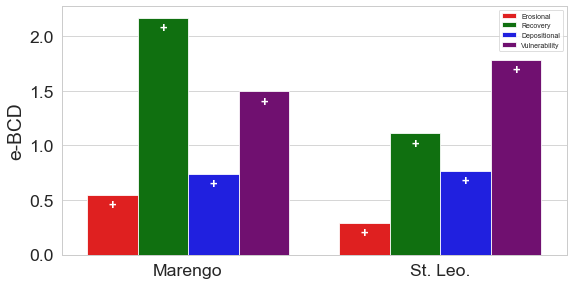

In [63]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

f,ax=plt.subplots(figsize=(8,4))

sb.set_context("paper", font_scale=0.8)
sb.set_style("whitegrid")

loc_order=["mar","leo"]

palette_dyn_states ={"Erosional":"r","Recovery":"g","Depositional":"b","Vulnerability":"purple"}
orders=["Erosional","Recovery","Depositional","Vulnerability"]

plot_bars=sb.barplot(data=e_bcds,x="location", y=e_bcds.coastal_markov_idx,hue="states_labels", hue_order=orders,
          order=loc_order, palette=palette_dyn_states)


ax.set_xticklabels(labels=["Marengo","St. Leo."])
ax.set_xlabel("")
ax.set_ylabel("e-BCD")


txt_heights=[i.get_height() for i in ax.patches]

signs=[]
for i in orders:
    for j in loc_order:
        sign=e_bcds.query(f"location == '{j}' & states_labels=='{i}'").sign.values
        signs.append(sign)
        

for p,txt_height,sign in zip(ax.patches,txt_heights,signs):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
         txt_height - 0.095, 
         sign[0], 
         horizontalalignment='center', 
         verticalalignment='center',
            color="white",
           fontsize=13,
           fontweight='heavy')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc=0)

plt.tight_layout()

#f.savefig(r'E:\\path\\to\\save\\picture.png', dpi=600); 

## Residual Beachface Cluster Dynamics (r-BCD)

We already computed the __Steady State__ probability vectors for each location using the __BCDs_compute__ function, storing it in the __ss__ variable.<br>
Here below we reorder the data and plot as an heatmap, where each columns is a location and each row a magnitude of change.


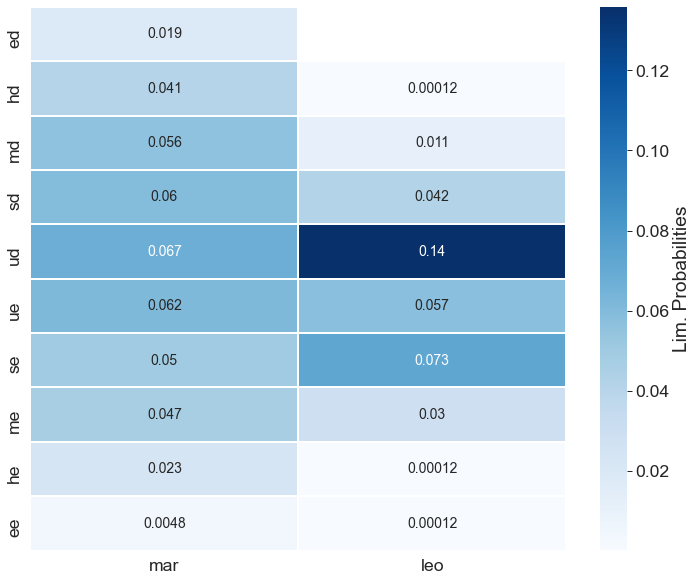

In [64]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)

ss_victoria_ordered=ss.loc[label_order,loc_order]
ss_victoria_ordered.drop("nnn",inplace=True)
ss_victoria_ordered

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)


f,ax=plt.subplots(figsize=(12,10))

sb.heatmap(ss_victoria_ordered, cmap="Blues",annot=True,
           annot_kws={'size':14},linewidths=1,linecolor="white", cbar_kws={'label': 'Lim. Probabilities'});

#f.savefig(r'E:\\path\\to\\save\\picture.png', dpi=600); 

### Computing the e-BCDs

The residual is simply the difference between erosional and depositional probabilities in the Steady-State distribution, __multiplicated by 100__ for readability purposes. Note that in this case, no weigths are applied as no transition is represented.


Here below, the dataframe returns the residual column, which is what you might want to map in Qgis.

In [65]:
# No weight are needed for the r-BCD index. Thus, we set a weigth dictionary of 1 (FUNCTION TO BE UPDATED).

weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Apply the weights (USELESS, to UPDATE)
steady_state_victoria_ordered_w=ss_victoria_ordered.join(weigths_series, how="inner")
weighted_matrix=steady_state_victoria_ordered_w.iloc[:,:-1].multiply(steady_state_victoria_ordered_w.weight, axis="index")

# Create erosion and deposition sub-matrix
erosion=weighted_matrix.iloc[5:,:].transpose()
erosion["erosion"]=erosion.sum(axis=1)

deposition=weighted_matrix.iloc[:-5,:].transpose()
deposition["deposition"]=deposition.sum(axis=1)

# Compute erosion residuals
indexes_vic=(deposition.deposition -erosion.erosion) * 100    # to make the indexes more readable
indexes_vic=pd.DataFrame(pd.Series(indexes_vic, name="residual"))
indexes_vic.reset_index(inplace=True)
indexes_vic.rename({"index":"location"},axis=1, inplace=True)

# Put all into one table
deposition["erosion"]=erosion.erosion
to_plot=deposition.reset_index()[["index","deposition","erosion"]].rename({"index":"location"},axis=1)

to_print_table=to_plot.merge(indexes_vic, on="location", how="left")
to_plot=to_print_table.melt(id_vars=["location"],var_name="process",value_name="coastal_index")


to_print_table

,location,deposition,erosion,residual
0,mar,0.243289,0.186929,5.635999
1,leo,0.189379,0.160689,2.869018


___

### GOOD!

Location level BCDs are good to compare multiple locations across wide areas. But what about getting a more detailed spatial-explicit view of the behaviour of a beachface system, at the transect-level?

Continue to the next notebook: __Example 5b - Beachface Cluster Dynamics indices - Transect level__